In [1]:
!pip install kaggle

In [2]:
import json

kaggle_credentials = json.load(open("kaggle.json"))

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [4]:
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls

best_model.pth	kaggle.json  PlantVillage  plant-village.zip  sample_data


In [6]:
from zipfile import ZipFile

with ZipFile("plant-village.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import random


In [8]:
# Augmentations for training
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128, scale=(0.6, 1.0)),  # Increase variety
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # 🔥 New: Rotate images randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 🔥 New: Random color changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformations for testing (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
full_dataset = datasets.ImageFolder(root="PlantVillage", transform=train_transform)

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

# Apply correct transformations
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

# Number of classes
num_classes = len(full_dataset.classes)
print(f"Dataset split: {train_size} train, {test_size} test.")
print(f"Number of Classes: {num_classes}")


Dataset split: 16510 train, 4128 test.
Number of Classes: 15


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class FasterCNN(nn.Module):
    def __init__(self, num_classes):
        super(FasterCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            DepthwiseSeparableConv(3, 64), nn.ReLU(), nn.BatchNorm2d(64),
            DepthwiseSeparableConv(64, 128), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            DepthwiseSeparableConv(128, 256), nn.ReLU(), nn.BatchNorm2d(256),
            DepthwiseSeparableConv(256, 512), nn.ReLU(), nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),

            DepthwiseSeparableConv(512, 512), nn.ReLU(), nn.BatchNorm2d(512),
            DepthwiseSeparableConv(512, 1024), nn.ReLU(), nn.BatchNorm2d(1024),
            nn.MaxPool2d(2, 2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [10]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = FasterCNN(num_classes=num_classes).to(device)

# Loss Function (Using Label Smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer (AdamW for better stability)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning Rate Scheduler (Cosine Annealing)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()


<ipython-input-11-2ba88017f6e9>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [12]:
num_epochs = 50
best_accuracy = 0.0
early_stop_count = 0
early_stop_threshold = 8

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    scheduler.step()

    # Validate Model
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

    # Save Best Model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print("✔ Model Saved!")
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count > early_stop_threshold:
        print("🔴 Early Stopping!")
        break

print(f"✅ Best Accuracy: {best_accuracy:.2f}%")


<ipython-input-12-600ac35d5925>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50], Loss: 1.2095, Accuracy: 89.17%
✔ Model Saved!


KeyboardInterrupt: 

In [13]:
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    scheduler.step()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # ✅ Store training loss

    # Validate Model
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)  # ✅ Store validation accuracy

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Save Best Model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "model.pth")
        print("✔ Model Saved!")
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count > early_stop_threshold:
        print("🔴 Early Stopping!")
        break

print(f"✅ Best Accuracy: {best_accuracy:.2f}%")


<ipython-input-13-3634ed31e3eb>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50], Loss: 2.3779, Accuracy: 75.53%
Epoch [2/50], Loss: 1.2683, Accuracy: 86.65%
Epoch [3/50], Loss: 1.0582, Accuracy: 90.77%
✔ Model Saved!
Epoch [4/50], Loss: 0.9590, Accuracy: 93.75%
✔ Model Saved!
Epoch [5/50], Loss: 0.8954, Accuracy: 94.38%
✔ Model Saved!
Epoch [6/50], Loss: 0.8407, Accuracy: 95.91%
✔ Model Saved!
Epoch [7/50], Loss: 0.8103, Accuracy: 95.76%
Epoch [8/50], Loss: 0.7788, Accuracy: 96.61%
✔ Model Saved!
Epoch [9/50], Loss: 0.7566, Accuracy: 97.00%
✔ Model Saved!
Epoch [10/50], Loss: 0.7383, Accuracy: 97.31%
✔ Model Saved!
Epoch [11/50], Loss: 0.7215, Accuracy: 97.75%
✔ Model Saved!
Epoch [12/50], Loss: 0.7081, Accuracy: 97.75%
Epoch [13/50], Loss: 0.6980, Accuracy: 98.06%
✔ Model Saved!
Epoch [14/50], Loss: 0.6832, Accuracy: 98.21%
✔ Model Saved!
Epoch [15/50], Loss: 0.6735, Accuracy: 98.40%
✔ Model Saved!
Epoch [16/50], Loss: 0.6641, Accuracy: 97.19%
Epoch [17/50], Loss: 0.6587, Accuracy: 98.18%
Epoch [18/50], Loss: 0.6505, Accuracy: 98.38%
Epoch [19/50], L

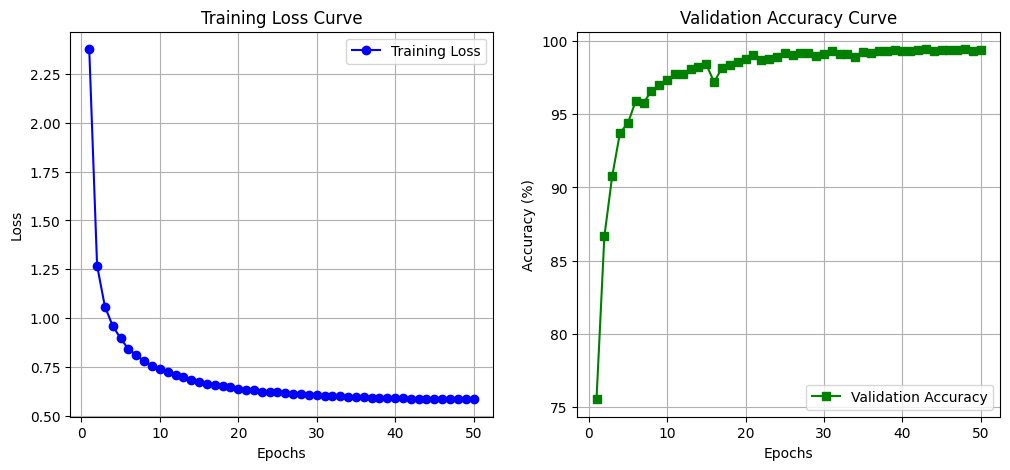

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 📌 Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()

# 📌 Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='s', color='g', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid()

plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


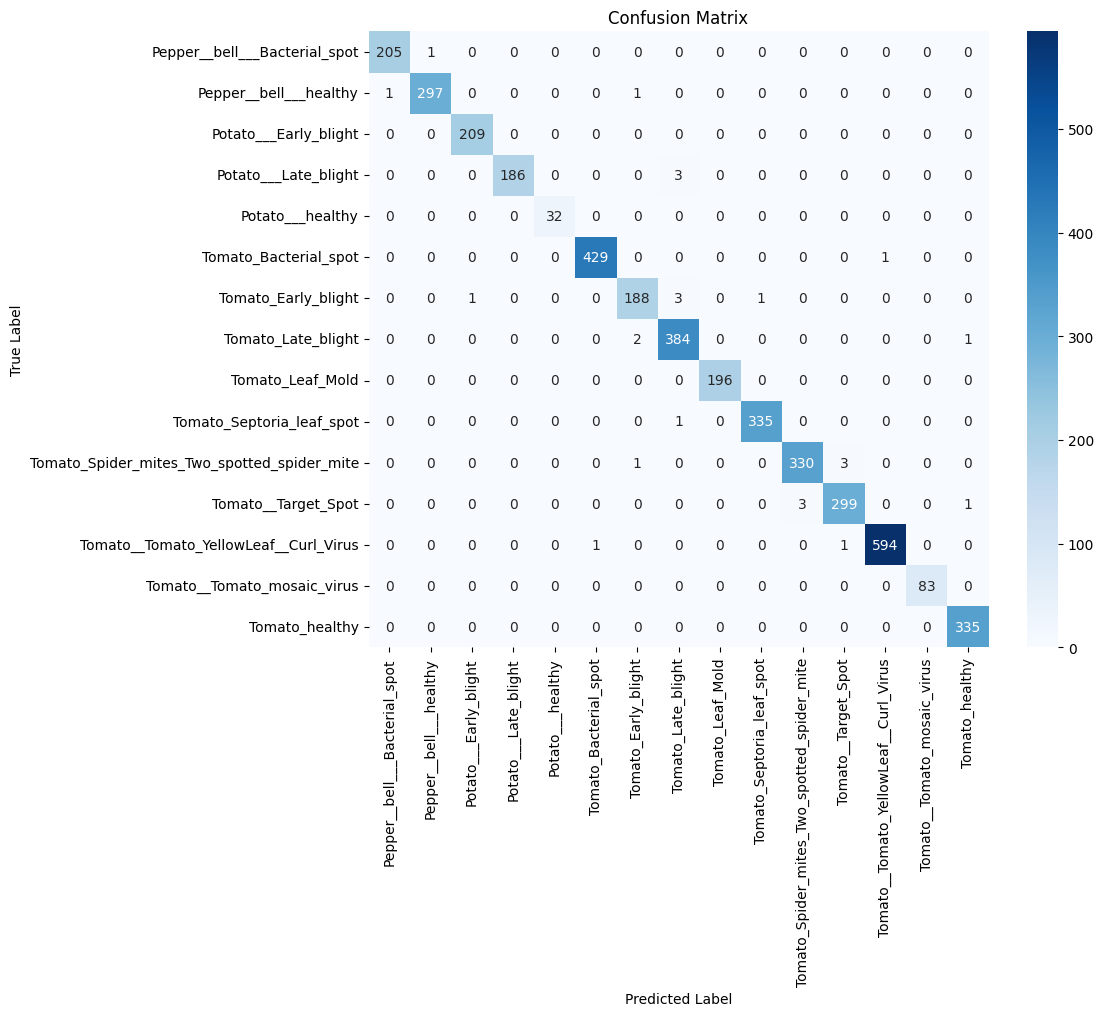

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 📌 Compute Predictions & True Labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 📌 Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = full_dataset.classes  # Get class labels

# 📌 Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
